In [1]:
!pip install pennylane --quiet
!pip install numpy --quiet
!pip install matplotlib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 19.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Final quantum state expectation value: 0.8800584874847646


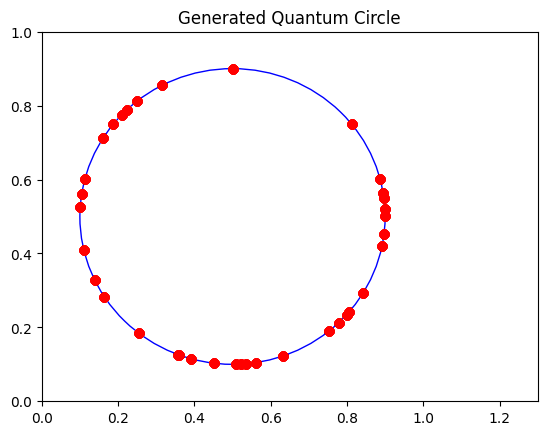

In [2]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# Define number of qubits used and the number of layers in the Quantum Circuit
num_qubits = 2
num_layers = 6
# Define the size of the parameter vector theta
theta_size = num_layers * num_qubits * 3

# Create the quantum device with the amount of qubits previously specified
dev = qml.device("default.qubit", wires=num_qubits)

# Define the quantum generator circuit that applies 'RY' rotations on each
# qubit for each layer.
def generator(theta):
    for l in range(num_layers):
        for q in range(num_qubits):
            qml.RY(theta[l*num_qubits + q], wires=q)

# Defines the discriminator quantum circuit that applies 'RY' rotations
# followed by 'CNOT' gates between qubits 0 and 1 for each layer.
def discriminator(phi):
    for l in range(num_layers):
        for q in range(num_qubits):
            qml.RY(phi[l*num_qubits + q], wires=q)
        qml.CNOT(wires=[0, 1])

# Create the Quantum Function that applies the generator circuit and returns
# the expectation value of the product of Pauli Z gate on the 0 qubit
# multiplied by Pauli Z gate on the 1 qubit
@qml.qnode(dev)
def qgan(theta, phi):
    generator(theta)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))  # Expectation value of the product

# Initializes 'theta' and 'phi' that starts training the QGAN
theta_init = np.random.uniform(low=-np.pi, high=np.pi, size=(theta_size,))
phi_init = np.random.uniform(low=-np.pi, high=np.pi, size=(num_layers * num_qubits,))

# Creates Gradient Descent Optimizer to be used to optimize the theta and phi
# values.
opt = qml.GradientDescentOptimizer(stepsize=0.01)

# Function to optimize 'theta' and 'phi' parameters using gradient descent.
iterations = 200
for it in range(iterations):
    theta = opt.step(lambda theta: -qgan(theta, phi_init), theta_init)
    phi = opt.step(lambda phi: -qgan(theta_init, phi), phi_init)


# Visualize the generated quantum state
theta_final = theta
phi_final = phi
result = qgan(theta_final, phi_final)
print("Final quantum state expectation value:", result)

# Plot the circle using matplotlib
def plot_circle(theta_final):
    fig, ax = plt.subplots()
    circle = plt.Circle((0.5, 0.5), 0.4, color='blue', fill=False)
    ax.add_artist(circle)
    plt.xlim(0, 1.3)
    plt.ylim(0, 1)
    plt.yscale('linear')
    plt.xscale('linear')
    plt.title('Generated Quantum Circle')

    # Generate points using the final parameters
    points = []
    for i in range(100):
        x = 0.5 + 0.4 * np.cos(theta_final)
        y = 0.5 + 0.4 * np.sin(theta_final)
        points.append([x, y])

    points = np.array(points)

    # Plot the points
    plt.scatter(points[:, 0], points[:, 1], color='red')

    plt.show()

plot_circle(theta_final)

Iteration 100, Loss: -0.06841736595772682
Iteration 200, Loss: -0.06841736595772682
Iteration 300, Loss: -0.06841736595772682
Iteration 400, Loss: -0.06841736595772682
Iteration 500, Loss: -0.06841736595772682
Iteration 600, Loss: -0.06841736595772682
Iteration 700, Loss: -0.06841736595772682
Iteration 800, Loss: -0.06841736595772682
Iteration 900, Loss: -0.06841736595772682
Iteration 1000, Loss: -0.06841736595772682
Reached maximum iterations without reaching threshold. Final quantum state expectation value: -0.06841736595772682


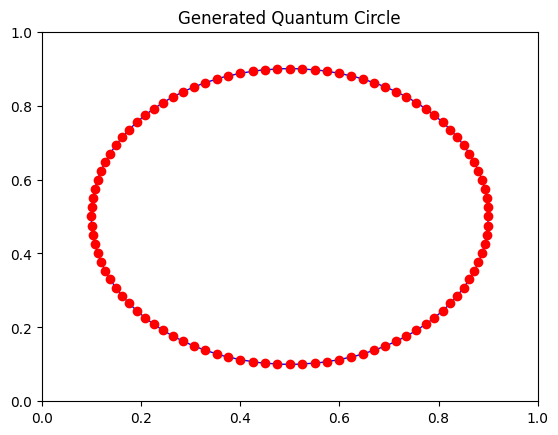

In [3]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# Define number of qubits used and the number of layers in the Quantum Circuit
num_qubits = 2
num_layers = 6
# Define the size of the parameter vector theta
theta_size = num_layers * num_qubits

# Create the quantum device with the amount of qubits previously specified
dev = qml.device("default.qubit", wires=num_qubits)

# Define the quantum generator circuit that applies 'RY' rotations on each
# qubit for each layer.
def generator(theta):
    for l in range(num_layers):
        for q in range(num_qubits):
            qml.RY(theta[l*num_qubits + q], wires=q)

# Defines the discriminator quantum circuit that applies 'RY' rotations
# followed by 'CNOT' gates between qubits 0 and 1 for each layer.
def discriminator(phi):
    for l in range(num_layers):
        for q in range(num_qubits):
            qml.RY(phi[l*num_qubits + q], wires=q)
        qml.CNOT(wires=[0, 1])

# Create the Quantum Function that applies the generator circuit and returns
# the expectation value of the product of Pauli Z gate on the 0 qubit
# multiplied by Pauli Z gate on the 1 qubit
@qml.qnode(dev)
def qgan(theta, phi):
    generator(theta)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))  # Expectation value of the product

# Function to optimize 'theta' and 'phi' parameters using gradient descent
# until either 'threshold' is met or 'max_iterations' is reached
def train_qgan(theta_init, phi_init, threshold, max_iterations=1000, current_iteration=0):
    opt = qml.GradientDescentOptimizer(stepsize=9)

    while current_iteration < max_iterations:
        theta = opt.step(lambda theta: -qgan(theta, phi_init), theta_init)
        phi = opt.step(lambda phi: -qgan(theta_init, phi), phi_init)
        result = qgan(theta, phi)

        current_iteration += 1

        if result >= threshold:
            print(f"Reached desired threshold with iteration {current_iteration}, Final quantum state expectation value: {result}")
            return theta, phi

        if current_iteration % 100 == 0:
            print(f"Iteration {current_iteration}, Loss: {result}")

    print(f"Reached maximum iterations without reaching threshold. Final quantum state expectation value: {result}")
    return theta, phi

# Initializes 'theta' and 'phi' that starts traing the QGAN until the desired
# 'threshold' value is achieved
theta_init = np.random.uniform(low=-np.pi, high=np.pi, size=(theta_size,))
phi_init = np.random.uniform(low=-np.pi, high=np.pi, size=(num_layers * num_qubits,))

# Defines the threshold we want our loss to get above
threshold = 0.9
theta_final, phi_final = train_qgan(theta_init, phi_init, threshold)

# Plot the final circle using matplotlib
def plot_circle(theta_final):
    fig, ax = plt.subplots()
    circle = plt.Circle((0.5, 0.5), 0.4, color='blue', fill=False)
    ax.add_artist(circle)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title('Generated Quantum Circle')

    # Generate points using the final parameters
    points = []
    for i in range(100):
        theta = i * 2 * np.pi / 100
        x = 0.5 + 0.4 * np.cos(theta)
        y = 0.5 + 0.4 * np.sin(theta)
        points.append([x, y])

    points = np.array(points)

    # Plot the points
    plt.scatter(points[:, 0], points[:, 1], color='red')

    plt.show()

plot_circle(theta_final)


